In [9]:
import matplotlib.pyplot as plt
import mitsuba as mi
import numpy as np
import numpy.typing as npt
from typing import cast

mi.set_variant("llvm_ad_spectral")

In [10]:
scene = mi.load_file("matpreview/scene.xml")

In [7]:
img = mi.render(scene)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


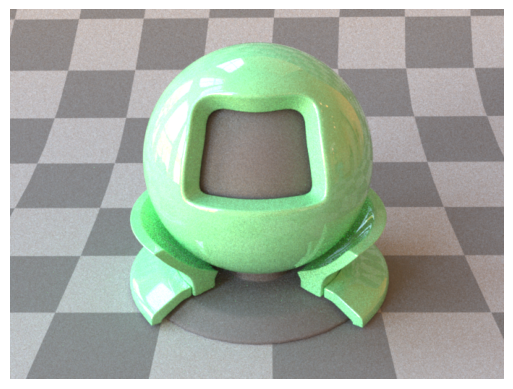

In [8]:
plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)) # approximate sRGB tonemapping